In [1]:
# Import Data Manipulation Libraries
import numpy as np
import pandas as pd

# Import Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import Filter warning Libraries
import warnings
warnings.filterwarnings('ignore')

# Import Logging
import logging
logging.basicConfig(level = logging.INFO,
                    filename = 'supplychain.log',
                    filemode = 'w',
                    format = '%(asctime)s - %(message)s - %(levelname)s',
                    force = True)

# Import OrderedDict Function
from collections import OrderedDict

# Importing Machine Learning models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,MinMaxScaler,LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
# Data Ingestion
df = pd.read_csv(r'E:\churnModelling_predictionData\data\raw\Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
data = df.drop(columns=['CustomerId', 'Surname'])
data.head()

,RowNumber,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [12]:
# Checking the skewness, IQR, min, max values and more
# First we segregate the numerical and categorical columns

numerical_col = data.select_dtypes(exclude = 'object').columns
categorical_col = data.select_dtypes(include = 'object').columns

# Numerical Descriptive stats
numerical_stats = []
Q1 = df[numerical_col].quantile(0.25)
Q3 = df[numerical_col].quantile(0.75)
IQR = Q3 - Q1
LW = Q1 - 1.5 * IQR
UW = Q3 + 1.5 * IQR

# Outlier count per column
Outlier_Count = ((df[numerical_col] < LW) | (df[numerical_col] > UW)).sum()
Outlier_Percentage = (Outlier_Count / len(df)) * 100

for i in numerical_col:
    num_stats = OrderedDict({
        "Feature": i,
        "Count": df[i].count(),
        "Maximum": df[i].max(),
        "Minimum": df[i].min(),
        "Mean": df[i].mean(),
        "Median": df[i].median(),
        "Q1": Q1[i],
        "Q3": Q3[i],
        "IQR": IQR[i],
        "Lower Whisker": LW[i],
        "Upper Whisker": UW[i],
        "Outlier_Count": Outlier_Count[i],
        "Outlier_Percentage": Outlier_Percentage[i],
        "Skewness": df[i].skew(),
        "Kurtosis": df[i].kurt(),
        "Standard Deviation": df[i].std()
    })
    numerical_stats.append(num_stats)

numerical_stats_report = pd.DataFrame(numerical_stats)
numerical_stats_report

,Feature,Count,Maximum,Minimum,Mean,Median,Q1,Q3,IQR,Lower Whisker,Upper Whisker,Outlier_Count,Outlier_Percentage,Skewness,Kurtosis,Standard Deviation
0,RowNumber,10000,10000.00,1.00,5000.500000,5000.500,2500.75,7500.2500,4999.5000,-4998.50000,14999.50000,0,0.00,0.000000,-1.200000,2886.895680
1,CreditScore,10000,850.00,350.00,650.528800,652.000,584.00,718.0000,134.0000,383.00000,919.00000,15,0.15,-0.071607,-0.425726,96.653299
2,Age,10000,92.00,18.00,38.921800,37.000,32.00,44.0000,12.0000,14.00000,62.00000,359,3.59,1.011320,1.395347,10.487806
3,Tenure,10000,10.00,0.00,5.012800,5.000,3.00,7.0000,4.0000,-3.00000,13.00000,0,0.00,0.010991,-1.165225,2.892174
4,Balance,10000,250898.09,0.00,76485.889288,97198.540,0.00,127644.2400,127644.2400,-191466.36000,319110.60000,0,0.00,-0.141109,-1.489412,62397.405202
5,NumOfProducts,10000,4.00,1.00,1.530200,1.000,1.00,2.0000,1.0000,-0.50000,3.50000,60,0.60,0.745568,0.582981,0.581654
6,HasCrCard,10000,1.00,0.00,0.705500,1.000,0.00,1.0000,1.0000,-1.50000,2.50000,0,0.00,-0.901812,-1.186973,0.455840
7,IsActiveMember,10000,1.00,0.00,0.515100,1.000,0.00,1.0000,1.0000,-1.50000,2.50000,0,0.00,-0.060437,-1.996747,0.499797
8,EstimatedSalary,10000,199992.48,11.58,100090.239881,100193.915,51002.11,149388.2475,98386.1375,-96577.09625,296967.45375,0,0.00,0.002085,-1.181518,57510.492818
9,Exited,10000,1.00,0.00,0.203700,0.000,0.00,0.0000,0.0000,0.00000,0.00000,2037,20.37,1.471611,0.165671,0.402769


In [14]:
categorical_stats = []

for i in categorical_col:
    cat_stats = OrderedDict({
        "Feature":i,
        "Count":df[i].count(),
        "Unique_Values":df[i].nunique(),
        "Mode":df[i].mode()[0],
        "Frequency of Mode":df[i].value_counts()
    })
    categorical_stats.append(cat_stats)

categorical_stats_report = pd.DataFrame(categorical_stats)
categorical_stats_report

,Feature,Count,Unique_Values,Mode,Frequency of Mode
0,Geography,10000,3,France,Geography France 5014 Germany 2509 Spai...
1,Gender,10000,2,Male,Gender Male 5457 Female 4543 Name: cou...


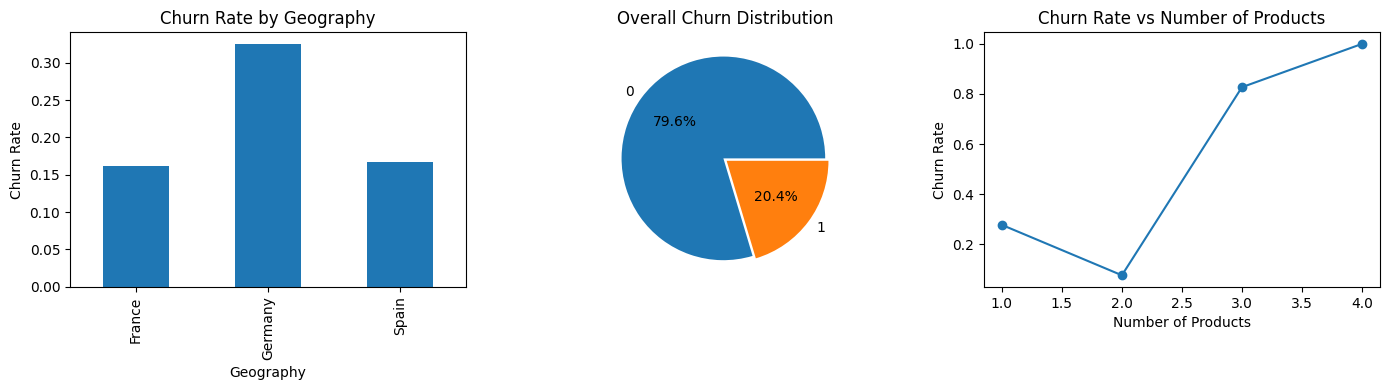

In [15]:
import matplotlib.pyplot as plt

# Prepare data
geo_churn = df.groupby('Geography')['Exited'].mean()
overall_churn = df['Exited'].value_counts()
product_churn = df.groupby('NumOfProducts')['Exited'].mean()

# Create subplots
plt.figure(figsize=(14, 4))

# 1️ Bar Chart: Geography-wise Churn
plt.subplot(1, 3, 1)
geo_churn.plot(kind='bar')
plt.title('Churn Rate by Geography')
plt.xlabel('Geography')
plt.ylabel('Churn Rate')

# 2️ Pie Chart: Overall Churn
plt.subplot(1, 3, 2)
overall_churn.plot(
    kind='pie',
    autopct='%0.1f%%',
    explode=[0.02, 0.02]
)
plt.title('Overall Churn Distribution')
plt.ylabel('')

# 3️ Line Chart: NumOfProducts vs Churn
plt.subplot(1, 3, 3)
product_churn.plot(marker='o')
plt.title('Churn Rate vs Number of Products')
plt.xlabel('Number of Products')
plt.ylabel('Churn Rate')

plt.tight_layout()
plt.show()

In [16]:
# Dataset for Female
Female_data = df[df['Gender'] == 'Female']

# Female customers who exited (1)
Exited_Female = df[
    (df['Gender'] == 'Female') & (df['Exited'] == 1)
]

# Female customers who not exited (0)
NotExited_Female = df[
    (df['Gender'] == 'Female') & (df['Exited'] == 0)
]

Exited_Female

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
22,23,15699309,Gerasimov,510,Spain,Female,38,4,0.00,1,1,0,118913.53,1
30,31,15589475,Azikiwe,591,Spain,Female,39,3,0.00,3,1,0,140469.38,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9956,9957,15707861,Nucci,520,France,Female,46,10,85216.61,1,1,0,117369.52,1
9960,9961,15681026,Lucciano,795,Germany,Female,33,9,104552.72,1,1,1,120853.83,1
9982,9983,15768163,Griffin,655,Germany,Female,46,7,137145.12,1,1,0,115146.40,1
9991,9992,15769959,Ajuluchukwu,597,France,Female,53,4,88381.21,1,1,0,69384.71,1


In [17]:
# Dataset for France
France_data = df[df['Geography'] == 'France']

# People who are from France and who exited i.e 1
Exited_France = df[
    (df['Geography'] == 'France') & (df['Exited'] == 1)
]

# People who are from France and who not exited i.e 0
NotExited_France = df[
    (df['Geography'] == 'France') & (df['Exited'] == 0)
]

# Saving CSV files
France_data.to_csv('France_Total_Data.csv', index=False)
Exited_France.to_csv('France_Exited_Data.csv', index=False)
NotExited_France.to_csv('France_Not_Exited_Data.csv', index=False)

In [18]:
# Dataset for Germany
Germany_data = df[df['Geography'] == 'Germany']

Exited_Germany = df[
    (df['Geography'] == 'Germany') & (df['Exited'] == 1)
]

NotExited_Germany = df[
    (df['Geography'] == 'Germany') & (df['Exited'] == 0)
]

Germany_data.to_csv('Germany_Total_Data.csv', index=False)
Exited_Germany.to_csv('Germany_Exited_Data.csv', index=False)
NotExited_Germany.to_csv('Germany_Not_Exited_Data.csv', index=False)

In [19]:
# Dataset for Spain
Spain_data = df[df['Geography'] == 'Spain']

Exited_Spain = df[
    (df['Geography'] == 'Spain') & (df['Exited'] == 1)
]

NotExited_Spain = df[
    (df['Geography'] == 'Spain') & (df['Exited'] == 0)
]

Spain_data.to_csv('Spain_Total_Data.csv', index=False)
Exited_Spain.to_csv('Spain_Exited_Data.csv', index=False)
NotExited_Spain.to_csv('Spain_Not_Exited_Data.csv', index=False)

In [20]:
# Dataset for Female customers
Female_data = df[df['Gender'] == 'Female']

# Female customers who exited (1) and are active members (1)
Female_Exited_Active = df[
    (df['Gender'] == 'Female') &
    (df['Exited'] == 1) &
    (df['IsActiveMember'] == 1)
]

# Female customers who exited (1) and are NOT active members (0)
Female_Exited_NotActive = df[
    (df['Gender'] == 'Female') &
    (df['Exited'] == 1) &
    (df['IsActiveMember'] == 0)
]

# Saving CSV files
Female_data.to_csv('Female_Total_Data.csv', index=False)
Female_Exited_Active.to_csv('Female_Exited_Active_Data.csv', index=False)
Female_Exited_NotActive.to_csv('Female_Exited_NotActive_Data.csv', index=False)

In [22]:
# Dataset for Female customers
Female_data = df[df['Gender'] == 'Female']

# Female customers who not exited (0) and are active members (1)
Female_NotExited_Active = df[
    (df['Gender'] == 'Female') &
    (df['Exited'] == 0) &
    (df['IsActiveMember'] == 1)
]

# Female customers who not exited (0) and are NOT active members (0)
Female_NotExited_NotActive = df[
    (df['Gender'] == 'Female') &
    (df['Exited'] == 0) &
    (df['IsActiveMember'] == 0)
]

# Saving CSV files
Female_data.to_csv('Female_Total_Data.csv', index=False)
Female_NotExited_Active.to_csv('Female_NotExited_Active_Data.csv', index=False)
Female_NotExited_NotActive.to_csv('Female_NotExited_NotActive_Data.csv', index=False)

In [23]:
# Dataset for Male customers
Male_data = df[df['Gender'] == 'Male']

# Male customers who exited (1) and are active members (1)
Male_Exited_Active = df[
    (df['Gender'] == 'Male') &
    (df['Exited'] == 1) &
    (df['IsActiveMember'] == 1)
]

# Male customers who exited (1) and are NOT active members (0)
Male_Exited_NotActive = df[
    (df['Gender'] == 'Male') &
    (df['Exited'] == 1) &
    (df['IsActiveMember'] == 0)
]

# Saving CSV files
Male_data.to_csv('Male_Total_Data.csv', index=False)
Male_Exited_Active.to_csv('Male_Exited_Active_Data.csv', index=False)
Male_Exited_NotActive.to_csv('Male_Exited_NotActive_Data.csv', index=False)

In [24]:
# Male customers who not exited (0) and are active members (1)
Male_NotExited_Active = df[
    (df['Gender'] == 'Male') &
    (df['Exited'] == 0) &
    (df['IsActiveMember'] == 1)
]

# Male customers who not exited (0) and are NOT active members (0)
Male_NotExited_NotActive = df[
    (df['Gender'] == 'Male') &
    (df['Exited'] == 0) &
    (df['IsActiveMember'] == 0)
]

# Saving CSV files
Male_NotExited_Active.to_csv('Male_NotExited_Active_Data.csv', index=False)
Male_NotExited_NotActive.to_csv('Male_NotExited_NotActive_Data.csv', index=False)

In [26]:
import pandas as pd

def generate_all_crosstabs(df):

    crosstabs = {}

    # 1. Gender vs Exited
    crosstabs['gender_vs_exited'] = pd.crosstab(
        df['Gender'],
        df['Exited'],
        normalize='index',
        margins=True
    )

    # 2. Geography vs Exited
    crosstabs['geography_vs_exited'] = pd.crosstab(
        df['Geography'],
        df['Exited'],
        normalize='index',
        margins=True
    )

    # 3. IsActiveMember vs Exited
    crosstabs['activity_vs_exited'] = pd.crosstab(
        df['IsActiveMember'],
        df['Exited'],
        normalize='index',
        margins=True
    )

    # 4. Gender vs IsActiveMember vs Exited
    crosstabs['gender_activity_vs_exited'] = pd.crosstab(
        [df['Gender'], df['IsActiveMember']],
        df['Exited'],
        normalize='index'
    )

    # 5. NumOfProducts vs Exited
    crosstabs['products_vs_exited'] = pd.crosstab(
        df['NumOfProducts'],
        df['Exited'],
        normalize='index',
        margins=True
    )

    # 6. Credit Card vs Exited
    crosstabs['creditcard_vs_exited'] = pd.crosstab(
        df['HasCrCard'],
        df['Exited'],
        normalize='index',
        margins=True
    )

    # 7. Geography vs Gender vs Exited
    crosstabs['geo_gender_vs_exited'] = pd.crosstab(
        [df['Geography'], df['Gender']],
        df['Exited'],
        normalize='index'
    )

    # 8. Balance (Zero / Non-zero) vs Exited
    df['BalanceGroup'] = df['Balance'].apply(
        lambda x: 'Zero Balance' if x == 0 else 'Non-Zero Balance'
    )

    crosstabs['balancegroup_vs_exited'] = pd.crosstab(
        df['BalanceGroup'],
        df['Exited'],
        normalize='index',
        margins=True
    )

    # 9. geo_activity vs IsActiveMember vs Exited
    crosstabs['geo_activity_vs_exited'] = pd.crosstab(
        [df['Geography'], df['IsActiveMember']],
        df['Exited'],
        normalize='index'
    )

    # 10. gender_activity vs exited
    crosstabs['gender_activity_vs_exited']= pd.crosstab(
        [df['Gender'], df['IsActiveMember']],
        df['Exited'],
        normalize='index'
    )

    return crosstabs

# Call the function outside of the definition
crosstab_results = generate_all_crosstabs(df)

# View any crosstab
crosstab_results['gender_vs_exited']

Exited,0,1
Gender,,
Female,0.749285,0.250715
Male,0.835441,0.164559
All,0.796300,0.203700


In [ ]:
# Controlling Data Leakage
'''
1. Split the Dataset into X and y
2. Split the Dataset into Train and Test Sets
3. Use Encoding Techniques on Categorical Features
4. Use Scaling Techniques on Numerical Features
5. Use SMOTE
'''
# 1. Split the Dataset into X and y
X = df.drop('Exited',axis=1)
y = df['Exited']
# 2. Split the Dataset into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 1)
# 3. Use Encoding Techniques on Categorical Features

# Segregate Categorical and Numerical Features
numerical_col = X.select_dtypes(exclude = 'object').columns
categorical_col = X.select_dtypes(include = 'object').columns
# Apply Label Encoding on Categorical Features
le = LabelEncoder()
for col in categorical_col:
    X_train[col] = le.fit_transform(X_train[col])  # Seen Data
    X_test[col] = le.transform(X_test[col])           # Unseen Data
# 4. Use Scaling Techniques on Numerical Features
sc = RobustScaler()
X_train[numerical_col] = sc.fit_transform(X_train[numerical_col])   # Seen Data
X_test[numerical_col] = sc.transform(X_test[numerical_col])   # Unseen Data

# 5. Use SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)  # Seen Data

In [29]:
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
'''
1. n_neighbors: 5 # Default value
2. p = 2 # Default value
3. n_jobs = none # Default value
-----------------------------------------
-Knn suffer with curse of Dimensionality
to tackel this issue following steps is necessary
------------------------------------------
1. reduce the High Dimension to low Dimension using PendingDeprecationWarning
'''


knn = KNeighborsClassifier(n_neighbors=10,
                           p = 2,
                           n_jobs = None).fit(X_train, y_train)

y_pred = knn.predict(X_test)
acc_knn = classification_report(y_test, y_pred)
print(acc_knn)

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      2373
           1       0.47      0.65      0.55       627

    accuracy                           0.77      3000
   macro avg       0.68      0.73      0.70      3000
weighted avg       0.81      0.77      0.79      3000



In [30]:
# SVC = Support Vector Classifier

from sklearn.svm import SVC

'''
1. SVM is used when there will be high dimension in the data
2. It used Kerenel function approach to evaluate answers in batches
3. This also uses kfold approach to evaluate the answer
---------------------------------------------------------------------
1. Kernel function : 'rbf' # default value
2. degree = 3  # Default value
3. gamma = 'scale' # Default value
4. coef0 = 0.0 # Default value
'''
svc = SVC().fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
svc_acc = classification_report(y_test, y_pred_svc)
print(svc_acc)

              precision    recall  f1-score   support

           0       0.91      0.83      0.87      2373
           1       0.52      0.71      0.60       627

    accuracy                           0.80      3000
   macro avg       0.72      0.77      0.73      3000
weighted avg       0.83      0.80      0.81      3000



In [31]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging Classifier": BaggingClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "SVC":SVC()}

for model_name, model in models.items():
    model.fit(X_train, y_train)  # Seen Data
    y_pred = model.predict(X_test)   # Unseen Data
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 50)

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      2373
           1       0.39      0.65      0.49       627

    accuracy                           0.72      3000
   macro avg       0.64      0.69      0.65      3000
weighted avg       0.78      0.72      0.74      3000

Confusion Matrix:
[[1740  633]
 [ 219  408]]
--------------------------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2373
           1       0.49      0.56      0.52       627

    accuracy                           0.78      3000
   macro avg       0.68      0.70      0.69      3000
weighted avg       0.80      0.78      0.79      3000

Confusion Matrix:
[[2002  371]
 [ 277  350]]
--------------------------------------------------
Model: Random Forest
              precision    recall  f1-score   support

           0       0.89      0